# Modelling of a power electricity mixsupporting the demand in France in 2050

by Elisa Escanez and Sébastien Castets

tutored by Aude Rondepierre and Charles Dossal

## Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pyomo.environ as pyo

import panel as pn 
from ipywidgets import interact_manual
import ipywidgets as widgets

from SimplifiedModel import SimplifiedModel

pn.extension()
from EolesModel import EolesModel

## Utils

In [2]:
col = {"offshore" : '#1f4e79', "onshore" : '#548235' , "pv" : "#ffc000", "phs" : "#bdd7ee", "battery" : "#7030a0", "biogas" :"#843c0c", "methanation": "#7f6000", "gas": "grey", "lake": "#4169E1", "river" : "#09F1D3"}
tec = ["offshore","onshore","pv","river","lake","biogas","phs","battery","methanation"]
stor = ["phs","battery","methanation"]

In [3]:
# Dashboard

def show(week,name):
    
    if name == "scen2006": 
        d = scen2006
        Volume = Volume_str_opti 
    else :
        d = pd.read_csv(name+"/"+name+"_hourly_generation.csv", index_col = 0, squeeze = True)
        Volume = pd.read_csv(name+"/"+name+"_Volume.csv", index_col = 0, squeeze = True)
        
    tec_aux = tec
    if not("river" in d.columns): tec_aux = list(set(tec_aux) - set(["river"]))
    if not("lake" in d.columns): tec_aux = list(set(tec_aux) - set(["lake"]))
    
    h  = 168*(week-1)+np.arange(1,169)
    ymin, ymax = -45,130
    h_ratio = np.ones(len(stor)+1)
    h_ratio[0] = 2 # 1er subplot 2 fois plus grand
    fig, axs = plt.subplots(len(stor)+1, figsize = (15,15),gridspec_kw={'height_ratios':h_ratio})
    
    # Stockage 
    sum_s = 0
    for i in stor: 
        sum_s += d["Storage " + i][h]
    for s in stor[::-1]:
        aux = "Storage " + s
        axs[0].fill_between(h, sum_s, color = col[s], label = aux)
        sum_s -= d[aux][h]

    # Production
    sum_g = 0
    for i in tec_aux: 
        sum_g += d[i][h]
    for gene in tec_aux[::-1]: 
        axs[0].fill_between(h,sum_g, color = col[gene], label = gene )
        sum_g -= d[gene][h]
    
    # Demande
    axs[0].plot(h, d["Electricity demand"][h], color = 'r' , label = "Demand",linewidth= 4)

    axs[0].vlines(x=np.linspace(h[0],h[-1],8),ymin = ymin, ymax = ymax,colors="black",linestyle='dotted',linewidth=2)
    axs[0].set_ylabel("Production (GWh)")
    axs[0].set_ylim(ymin,ymax)
    axs[0].legend(loc ="upper right")
    axs[0].set_title("Semaine "+ str(week))
        
    for s in range(0,len(stor)):
        axs[s+1].fill_between(h, d["Stored " + stor[s]][h], color = col[stor[s]])
        axs[s+1].hlines(y=Volume[s], xmin = h[0], xmax = h[-1], label = "limit", color = 'red')
        axs[s+1].set_title("Stored " + str(stor[s]))
        axs[s+1].vlines(x=np.linspace(h[0],h[-1],8),ymin = 0, ymax = Volume[s]+10,colors="black",linestyle='dotted',linewidth=2)
        
        
def affichage(simu):
    print(" --- Q ---")
    for i in simu.model.Q:
        print(i," : ",pyo.value(simu.model.Q[i]))   
    print(" --- S ---")   
    for i in simu.model.S:
        print(i," : ",pyo.value(simu.model.S[i]))
    print(" --- volume ---")
    for i in simu.model.volume:
        print(i," : ",pyo.value(simu.model.volume[i]))
    print(" --- cost --- ")
    print(simu.cost())

# 1. Anlyze of outputs from P. Quirion

In [4]:
scenarios = pd.read_csv("outputs/scenarios.csv", index_col="scen")
cost_decomposition = pd.read_csv("outputs/cost decomposition for all scenarios.csv", index_col="scen")

In [5]:
scen = 157 #choosen scenario 
list(scenarios.iloc[scen][5:])

['central', 'central', 'central', 'central', 'central']

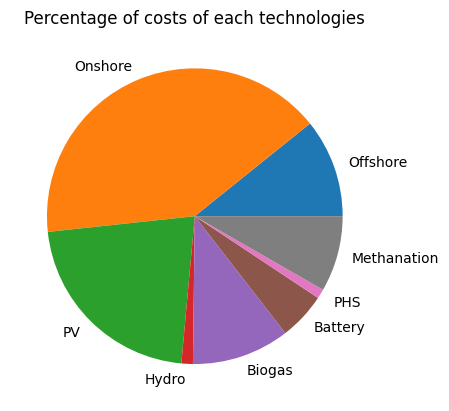

In [6]:
plt.figure()
plt.pie(list(map(lambda x: float(x[:-1]),list(cost_decomposition.iloc[scen]))), labels = ["Offshore","Onshore","PV","Hydro","Biogas","Battery","PHS","Methanation"])
plt.title("Percentage of costs of each technologies")
plt.show()

In [7]:
# Optimization results
scen2006 = pd.read_csv("outputs/2006_LC_internalized.csv", index_col = "hour")
scen2006.columns = ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'gas', 'phs',
       'battery', 'methanation', 'Electricity demand', 'Storage phs', 'Storage battery', 'Storage methanation', 'Stored battery',
       'Stored phs', 'Stored methanation', 'elec_price', 'gas_price']
scen2006.head()

,offshore,onshore,pv,river,lake,biogas,gas,phs,battery,methanation,Electricity demand,Storage phs,Storage battery,Storage methanation,Stored battery,Stored phs,Stored methanation,elec_price,gas_price
hour,,,,,,,,,,,,,,,,,,,
0,10.93,40.80,0.0,1.27,0.0,0.0,0.0,0.00,0.0,0.0,28.69,-9.30,-7.35,-7.66,31.75,82.95,1813.37,0.0,0.0
1,0.00,42.09,0.0,1.30,0.0,0.0,0.0,0.00,0.0,0.0,31.21,-4.52,0.00,-7.66,38.37,91.78,1817.90,0.0,0.0
2,11.12,31.67,0.0,0.00,0.0,0.0,0.0,1.87,0.0,0.0,27.70,-9.30,0.00,-7.66,38.37,96.08,1822.42,0.0,0.0
3,0.00,43.18,0.0,1.12,0.0,0.0,0.0,0.00,0.0,0.0,27.99,-8.65,0.00,-7.66,38.37,102.84,1826.94,0.0,0.0
4,2.17,42.95,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,28.16,-9.30,0.00,-7.66,38.37,111.06,1831.46,0.0,0.0


In [8]:
# Optimal values found
Volume_str_opti = pd.Series([180 ,74.14, 12499.09], index = stor)
S_opti = pd.Series([9.3,20.08, 7.66], index = stor)
Q_tec_opti = pd.Series([12.64, 79.73, 121.98, 7.5, 13 ,32.93, 9.3, 20.08, 32.93], index = tec)
Cost_opti = 21.84 

# 2. Simulation of the EOLES model
## 2.1. Choice of Q, S and VOLUME

In [9]:
phs_bounds = {"Q_lower":5.2,"Q_upper": 9.3, "S_lower":4.2, "S_upper":9.3, "Volume_lower":80.16, "Volume_upper":180}
vre_upper_bounds = {"onshore":120, "offshore": 20, "pv": 218}

In [10]:
V = widgets.Text(value='Storage volume (GWh)', disabled=True)
Volume_phs = widgets.FloatSlider(min=phs_bounds["Volume_lower"], max=phs_bounds["Volume_upper"], step=0.01, description='Volume phs',value = Volume_str_opti["phs"])
Volume_methanation = widgets.FloatSlider(min=0, max=Volume_str_opti["methanation"]*5, step=0.01, description='Volume methanation',value = Volume_str_opti["methanation"])
Volume_battery =  widgets.FloatSlider(min=0, max=Volume_str_opti["battery"]*5, step=0.01, description='Volume battery',value = Volume_str_opti["battery"])  

Q = widgets.Text(value='Installed capacity (GW)', disabled=True)
Q_offshore= widgets.FloatSlider(min=0, max=vre_upper_bounds["offshore"], step=0.01, description='Q offshore',value = Q_tec_opti["offshore"])
Q_onshore= widgets.FloatSlider(min=0, max=vre_upper_bounds["onshore"], step=0.01, description='Q onshore',value = Q_tec_opti["onshore"])
Q_pv= widgets.FloatSlider(min=0, max=vre_upper_bounds["pv"], step=0.1, description='Q pv',value = Q_tec_opti["pv"])
Q_river= widgets.FloatSlider(min=0, max=Q_tec_opti["river"], step=0.01, description='Q river',value = Q_tec_opti["river"])
Q_lake= widgets.FloatSlider(min=12.855, max=13, step=0.01, description='Q lake',value = Q_tec_opti["lake"])
Q_biogas= widgets.FloatSlider(min=0, max=Q_tec_opti["biogas"]*5, step=0.01, description='Q biogas',value = Q_tec_opti["biogas"])
Q_phs= widgets.FloatSlider(min=phs_bounds["Q_lower"], max=phs_bounds["Q_upper"], step=0.01, description='Q phs',value = Q_tec_opti["phs"])
Q_battery= widgets.FloatSlider(min=0, max=Q_tec_opti["battery"]*5, step=0.01, description='Q battery',value = Q_tec_opti["battery"])
Q_methanation= widgets.FloatSlider(min=0, max=Q_tec_opti["methanation"]*5, step=0.01, description='Q methanation',value = Q_tec_opti["methanation"])

S = widgets.Text(value='Charging capacity (GW)', disabled=True)
S_phs= widgets.FloatSlider(min=phs_bounds["S_lower"], max=phs_bounds["S_upper"], step=0.01, description='S phs',value = S_opti["phs"])
S_methanation = widgets.FloatSlider(min=0, max=S_opti["methanation"]*5, step=0.01, description='S methanation',value = S_opti["methanation"])
warn = widgets.Textarea(value='      Be careful ! \n      Volume > Q  et  Volume > S', disabled=True)

widgets.HBox([widgets.VBox([Q, Q_offshore, Q_onshore, Q_pv, Q_river, Q_lake,Q_biogas ,Q_phs,Q_battery,Q_methanation]),
widgets.VBox([V,Volume_phs,Volume_battery,Volume_methanation, warn]), widgets.VBox([S,S_methanation, S_phs])])


In [11]:
Q_tec = [Q_offshore.value, Q_onshore.value, Q_pv.value, Q_river.value, Q_lake.value,Q_biogas.value ,Q_phs.value,Q_battery.value,Q_methanation.value]
Volume_str = [Volume_phs.value,Volume_battery.value,Volume_methanation.value]
S =  [Q_phs.value,Q_battery.value,S_methanation.value]

# Capacity in GW Q
Q_tec = pd.Series( Q_tec, index = tec)

# Energy volume of storage technology in GWh VOLUME
Volume_str =pd.Series(Volume_str, index = stor)

#Storage charging power S
S =pd.Series(S, index = stor)

print("Fixed values : ")
print("--------- Q ---------")
print(Q_tec)
print("-------- VOLUME -------")
print(Volume_str)
print("--------- S ---------")
print(S)

Fixed values : 
--------- Q ---------
offshore        12.64
onshore         79.73
pv             121.98
river            7.50
lake            13.00
biogas          32.93
phs              9.30
battery         20.08
methanation     32.93
dtype: float64
-------- VOLUME -------
phs              180.00
battery           74.14
methanation    12499.09
dtype: float64
--------- S ---------
phs             9.30
battery        20.08
methanation     7.66
dtype: float64


## 2.2 Simulation with simplified model

In [12]:
# Run the simulation
simu = SimplifiedModel(Q_tec, Volume_str, S)
simu.load_param("inputs/")
simu.run()

Technologies used : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Parameters loading ...
Sets initialization...
Definition of variables to optimize ...
Adding constraints ...
Optimization ...
Model simulation successfully completed !


In [13]:
# Write results
res = simu.write_results('simu')

Writing and exporting results ...


## 2.3 Analyze of the results

In [14]:
noms_simu = ["scen2006", "simu_opti", 'simu_scen2', 'simu_scen3', 'simu_scen4']
# Dashboard
interactive_plot = interact_manual(show, week=widgets.IntText(value = 1), name = noms_simu)
interactive_plot

interactive(children=(IntText(value=1, description='week'), Dropdown(description='name', options=('scen2006', …

<function __main__.show(week, name)>

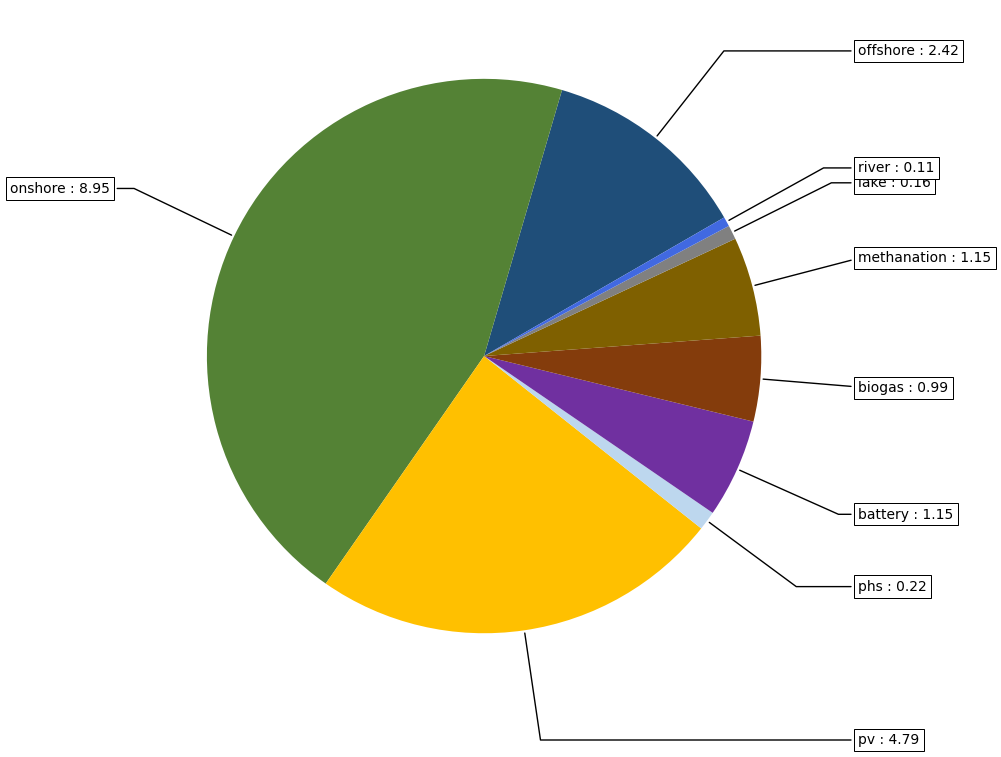

In [15]:
cost_tecs = {}

for t in ['offshore','onshore','pv','phs', 'battery','biogas','methanation','lake','river']:
          cost_tecs[t] = pyo.value(simu.cost_by_tec(t))
        
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(aspect="equal"))
data = cost_tecs.values()
recipe = [i + " : "+str(round(cost_tecs[i], 2) )for i in ['offshore','onshore','pv','phs', 'battery','biogas','methanation','lake','river'] ]


wedges, texts = ax.pie(data, startangle=30, colors = col.values())

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1 
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)


plt.show()

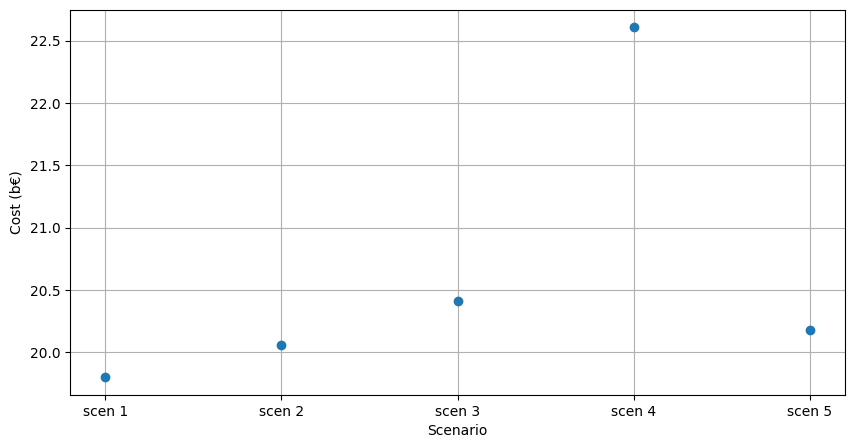

In [16]:
plt.figure(figsize=(10,5))
plt.plot([19.801,20.059,20.409,22.608,20.180], 'o')
plt.xticks(np.arange(5), labels = ["scen 1", "scen 2", "scen 3", "scen 4", "scen 5"])
plt.grid()
plt.ylabel("Cost (b€)")
plt.xlabel("Scenario")
plt.show()

# 3. Simulation of the full EOLES model with optimization of all the variables
## 3.1 Scenarios building

In [17]:
vre_profile = pd.read_csv("inputs/vre_profiles2006.csv", index_col=[0, 1], header=None).squeeze("columns")
vre_profile.head()

0         1
offshore  0    0.865143
          1    0.880000
          2    0.880000
          3    0.873429
          4    0.852000
Name: 2, dtype: float64

In [18]:
# scenario 2
sem1 = 28
sem2 = 48
nb_h = 24*7

vre_profile2 = vre_profile
vre_profile2["pv"][sem1*nb_h: (sem1+1)*nb_h] =  vre_profile2["pv"][sem2*nb_h: (sem2+1)*nb_h] 

C:\Users\sbcas\AppData\Local\Temp\ipykernel_7600\1904388035.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  vre_profile2["pv"][sem1*nb_h: (sem1+1)*nb_h] =  vre_profile2["pv"][sem2*nb_h: (sem2+1)*nb_h]


In [19]:
# scenario 3
vre_profile3 = vre_profile2
vre_profile3["pv"][29*nb_h: (29+1)*nb_h] =  vre_profile3["pv"][sem2*nb_h: (sem2+1)*nb_h] 
vre_profile3["pv"][30*nb_h: (30+1)*nb_h] =  vre_profile3["pv"][sem2*nb_h: (sem2+1)*nb_h] 
vre_profile3["pv"][31*nb_h: (31+1)*nb_h] =  vre_profile3["pv"][sem2*nb_h: (sem2+1)*nb_h] 

C:\Users\sbcas\AppData\Local\Temp\ipykernel_7600\3083592246.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  vre_profile3["pv"][29*nb_h: (29+1)*nb_h] =  vre_profile3["pv"][sem2*nb_h: (sem2+1)*nb_h]
C:\Users\sbcas\AppData\Local\Temp\ipyker

(7560.0, 7728.0)

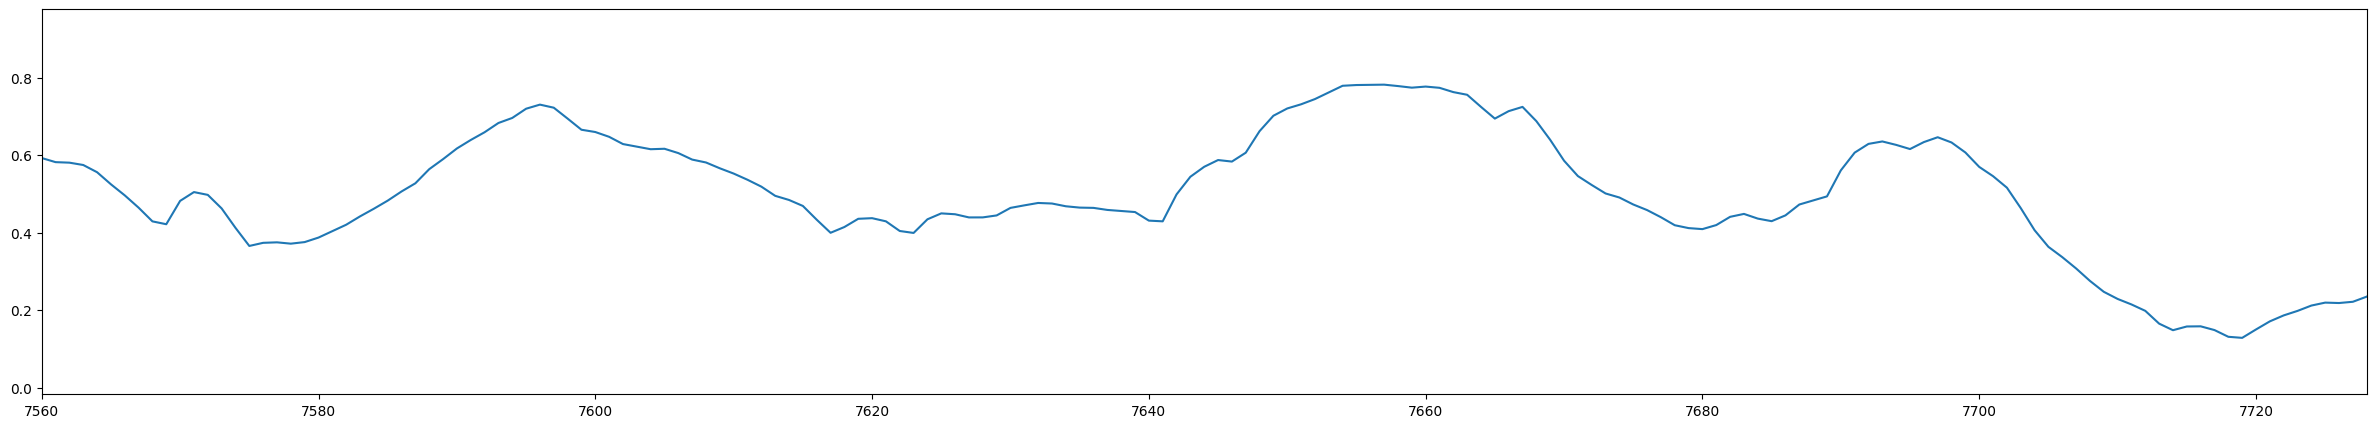

In [20]:
# scenario 4
nb_h = 24*7
sem = 45
plt.figure(figsize = (30,5))
plt.plot(vre_profile["onshore"])
plt.xlim(sem*nb_h,(sem+1)*nb_h)

In [21]:
# scenario 5
river_profile = pd.read_csv("inputs/run_of_river.csv", header = None , index_col = 0).squeeze("columns")
river_profile[23*nb_h:36*nb_h] = 0
river_profile.to_csv("river_profile_scen5.csv", header = False)

## 3.2. Run the optimization

In [23]:
simu1 = EolesModel()
simu1.load_param("inputs/")
simu1.run()
affichage(simu1)

Loading parameters ...
Sets initialization...
Definition of variables to optimize ...
WARNING (W1002): Setting Var 'S[phs]' to a numeric value `0` outside the
bounds (4.2, 6.2).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'S[phs]' to a numeric value `0` outside the
bounds (4.2, 6.2).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'volume[phs]' to a numeric value `0` outside the
bounds (80.16, 135.5).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'volume[phs]' to a numeric value `0` outside the
bounds (80.16, 135.5).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Adding constraints ...
Optimisation ...
Model simulation successfully completed !
 --- Q ---
offshore  :  20.0
onshore  :  120.0
pv  :  153.59165
river  :  7.5
lake  :  12.855
biogas  :  32.453756
phs  :  6.3936009
battery  :  33.875077
methanation

In [ ]:
simu2 = EolesModel()
simu2.load_param("inputs/", name_load_factor = "vre_profile_scen2.csv")
simu2.run()
affichage(simu2)

## 3.3 Results 

In [ ]:
cost_per_tec_noise10 = pd.read_csv("cout_par_tec_noise10.csv", index_col=0)
cost_per_tec_noise1 = pd.read_csv("couts_par_tec_noise1.csv", index_col=0)
cost_per_tec_noise20 = pd.read_csv("cout_par_tec_noise20.csv", index_col=0)

cost_per_tec_noise1 = cost_per_tec_noise1.rename(columns = {"0": "noise_1"})
cost_per_tec_noise10 = cost_per_tec_noise10.rename(columns = {"0": "noise_10"})
cost_per_tec_noise20 = cost_per_tec_noise20.rename(columns = {"0": "noise_20"})
cost_per_tec = pd.concat([cost_per_tec_noise1, cost_per_tec_noise10, cost_per_tec_noise20], axis = 1)

plt.figure(figsize=(15,5))
plt.plot(cost_per_tec["noise_1"], 'o', label = "mean noise = 1")
plt.plot(cost_per_tec["noise_10"], 'o', label = "mean noise = 10")
plt.plot(cost_per_tec["noise_20"], 'o', label = "mean noise = 20")
plt.grid()
plt.legend()
plt.ylabel("Cost (b€)")
plt.xlabel("technology")
plt.show()

In [ ]:
cost_1 = np.load("cout_noise1.npy")
cost_10 = np.load("cout_noise10.npy")
cost_20 = np.load("cout_noise20.npy")

plt.figure(figsize = (10,5))
plt.boxplot([cost_1 ,cost_10, cost_20])
plt.ylabel("Cost (b€)")
plt.xlabel("Mean of the noise")
plt.xticks([1,2,3], ['1', '10', '20'])
plt.grid()
plt.show()

## Materials comparison

### PHS

existing phs : https://www.hydropower.org/hydropower-pumped-storage-tool

phs liter conversion : https://www.connaissancedesenergies.org/fiche-pedagogique/hydroelectricite-stations-de-transfert-d-energie-par-pompage-step 

In [ ]:
conversion_liter_phs = 0.272e-6  # kWh for 1m3 of water at 100 m 

print("A PHS Volume of ",Volume_str["phs"], " GWh,  is equivalent to storing ", round(Volume_str["phs"]/conversion_liter_phs*1.e-6), " Gm3 of water at an altitude of 100m.")

existing_phs_volume = 80.16
phs_to_add = round((Volume_str["phs"]-existing_phs_volume)/conversion_liter_phs*1.e-6)
print("In addition to what currently exists, we need to store another ", phs_to_add, "Gm3 of water at a height of 100m.")

### Offshore + onshore

number and installed capacities : https://assets.rte-france.com/prod/public/2021-11/BP2050_rapport-complet_chapitre4_production-electricite_0.pdf 


In [24]:
Q_moy_turbine = 2e-3 #1.67e-3  #GW

print("We need ", round(Q_tec["onshore"]/Q_moy_turbine), " onshore wind turbines.")
print("We need ", round(Q_tec["offshore"]/Q_moy_turbine), " offshore wind turbines.")

nb_onshore = 8000 #+ de 8000 from RTE
print(round(Q_tec["onshore"]/Q_moy_turbine) - nb_onshore, " onshore wind turbines left to be built.")

# other way to compute
Q_onshore_existant = 17.4  #GW from RTE
print(round((Q_tec["onshore"]-Q_onshore_existant)/Q_moy_turbine) , " onshore wind turbines left to be built.")

existing_offshore_Q = 0
nb_offshore = 0
print(round(Q_tec["offshore"]/Q_moy_turbine) - nb_offshore, " offshore wind turbines left to be built.")

We need  39865  onshore wind turbines.
We need  6320  offshore wind turbines.


## Solar panels
from RTE et Ademe : 
https://www.quelleenergie.fr/economies-energie/panneaux-solaires-photovoltaiques/technique

In [ ]:
existing_pv_Q = 11.7  #GW from RTE or #9.934 GW in 2019 from Ademe
Q_moy_pv = 1.5e-6 #GW for a surface of 15m2 of solar panels  (between 1.5 kW and 3kW for 15 to 30m2 for 1 average pv) 
print(round((Q_tec["onshore"]-existing_pv_Q)/Q_moy_pv) , " solar panels to be built.")

### Batteries

from : https://www.bfmtv.com/economie/electricite-verte-le-plus-grand-site-de-stockage-sur-batteries-de-france-mis-en-service-en-2021_AN-202010040115.html

In [ ]:
Conv_battery_Wh = 24e-3/5685 #Wh from RTE
Conv_weight_Wh = 24e-3/270
print("We need ", round(Q_tec["battery"]/Conv_battery_Wh), " batteries, equivalent to ", round(Q_tec["battery"]/Conv_weight_Wh), "tons of batteries.")